In [1]:
import pandas as pd
import numpy as np
import os
import sys
import boto3
from dynamo import *
from utils import *
import time
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorly.decomposition import non_negative_parafac
import tensorly as tl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
AWS_KEY = os.environ['AWS_KEY']
AWS_SECRET = os.environ['AWS_SECRET']

In [3]:
db = boto3.resource(service_name='dynamodb',
                    region_name='us-east-1',
                    aws_access_key_id=AWS_KEY,
                    aws_secret_access_key=AWS_SECRET)

In [10]:
sample_size=600

In [22]:

bows = temporal_topic_extraction(2019, sample_size, db, throttled=False)


Creating process 1 to sample UIDs for month 2
Creating process 2 to sample UIDs for month 3
Creating process 3 to sample UIDs for month 4
Creating process 4 to sample UIDs for month 5
Creating process 5 to sample UIDs for month 6
Creating process 6 to sample UIDs for month 7
Creating process 7 to sample UIDs for month 8
Checking for cached UIDs for 2019/1
Checking for cached UIDs for 2019/6
Checking for cached UIDs for 2019/2
Checking for cached UIDs for 2019/3
Checking for cached UIDs for 2019/4
Checking for cached UIDs for 2019/5
Creating process 8 to sample UIDs for month 9
Cache found - loading from local
Cache found - loading from local
Cache found - loading from local
Cache found - loading from local
Checking for cached UIDs for 2019/7
Cache found - loading from local
Cache found - loading from local
Creating process 9 to sample UIDs for month 10
Creating process 10 to sample UIDs for month 11
Checking for cached UIDs for 2019/9
Checking for cached UIDs for 2019/8
Creating proces

In [23]:
b = [' '.join(y) for x in bows for y in x]

In [24]:
vectorizer = TfidfVectorizer(max_features=10000)
X = np.array(vectorizer.fit_transform(b).todense()).astype(np.float32)


In [25]:
t = np.dstack([X[i*sample_size:(i+1)*sample_size] for i in range(12)]).transpose(1,0,2)

In [26]:
w,f = non_negative_parafac(tensor=tl.tensor(t), rank=12, n_iter_max=10000)

In [16]:
def plotit3(array, title, yaxis=None, xaxis=None, ylabel=None, xlabel=None):
    plt.figure(figsize=(15,8))
    sns.heatmap(array, cmap='Blues')
    plt.title(title)
    if yaxis:
        plt.yticks(range(len(yaxis)),yaxis, rotation=0)
    if xaxis:
        plt.xticks(xaxis)
    if ylabel:
        plt.ylabel(ylabel)
    if xlabel:
        plt.xlabel(xlabel)
    plt.show()

In [17]:
# function to convert the most important vectorized terms back to words
def get_topics(array, threshold, vectorizer):
    
    #extract the location of the highest values above threshold sorted highest to lowest
    top_words = sorted(np.argwhere(array > threshold).ravel().tolist(), reverse=True)
    
    #convert back to words and return
    return np.array(vectorizer.get_feature_names())[top_words]

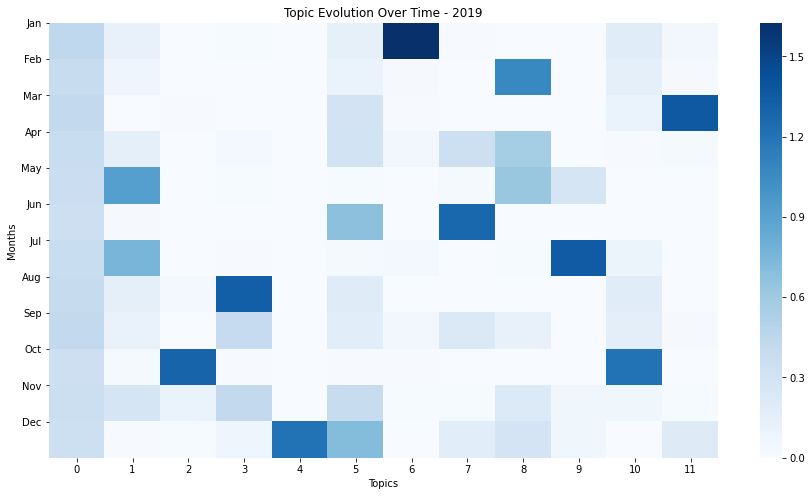

In [27]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
plotit3(f[2], 'Topic Evolution Over Time - {}'.format(2019), yaxis=months, ylabel='Months', xlabel='Topics')

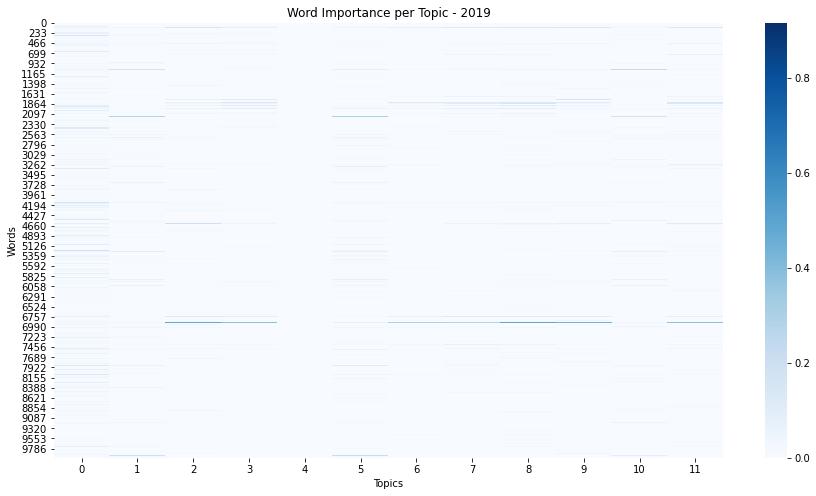

In [28]:
#visualize word importance per topic - should be mode-1 matrix
plotit3(f[0], 'Word Importance per Topic - {}'.format(2019), ylabel='Words', xlabel='Topics')

In [29]:
#get the words for each topic
words_per_topic = [get_topics(f[0][:,i], 0.2, vectorizer) for i in range(12)]
for pos, topic in enumerate(words_per_topic):
    print('\nTopic {}: {}'.format(pos, topic))


Topic 0: ['year' 'write' 'world' 'work' 'woman' 'well' 'week' 'want' 'two' 'time'
 'three' 'tell' 'take' 'story' 'statement' 'state' 'start' 'show' 'see'
 'right' 'reuter' 'report' 'police' 'play' 'percent' 'people' 'one' 'new'
 'need' 'million' 'may' 'many' 'make' 'look' 'life' 'late' 'last' 'know'
 'include' 'home' 'help' 'group' 'good' 'give' 'game' 'first' 'find'
 'family' 'even' 'day' 'country' 'company' 'come' 'city' 'change' 'call'
 'back' 'add' 'accord']

Topic 1: ['trade' 'stock' 'rise' 'rate' 'quarter' 'price' 'oil' 'market' 'low'
 'investor' 'index' 'high' 'growth' 'global' 'gain' 'fall' 'euro'
 'economy' 'dollar' 'cut' 'central' 'billion' 'bank']

Topic 2: ['white' 'whistleblower' 'ukrainian' 'ukraine' 'trump' 'republican'
 'president' 'official' 'mr' 'inquiry' 'impeachment' 'house' 'giuliani'
 'democratic' 'democrat' 'biden']

Topic 3: ['trump' 'republican' 'president' 'impeachment' 'house' 'hill'
 'democratic' 'democrat']

Topic 4: ['story' 'require' 'read' 'prime' 'memb